## Machine Learning Pipeline: Wrapping up for Deployment


In the previous notebooks, we worked through the typical Machine Learning pipeline steps to build a regression model that allows us to predict house prices. Briefly, we transformed variables in the dataset to make them suitable for use in a Regression model, then we selected the most predictive variables and finally we trained our model.

Now, we want to deploy our model. We want to create an API, which we can call with new data, with new characteristics about houses, to get an estimate of the price. In order to do so, we need to write code in a very specific way.

Here, we will summarise the key pieces of code, that we need to take forward for this particular project, to put our model in production.

Let's go ahead and get started.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# to divide train and test set
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action="ignore")

## Load data

We need the training data to train our model in the production environment. 

In [2]:
# load dataset
data = pd.read_csv('dataset/housing_train.csv')
print(data.shape)
data.head()

(265190, 22)


,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,1,1,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al


In [3]:
data.isna().mean().sort_values(ascending=False)

parking_options            0.358743
laundry_options            0.204800
lat                        0.005351
long                       0.005351
description                0.000008
state                      0.000004
beds                       0.000000
url                        0.000000
region                     0.000000
region_url                 0.000000
price                      0.000000
type                       0.000000
sqfeet                     0.000000
dogs_allowed               0.000000
baths                      0.000000
cats_allowed               0.000000
smoking_allowed            0.000000
wheelchair_access          0.000000
electric_vehicle_charge    0.000000
comes_furnished            0.000000
image_url                  0.000000
id                         0.000000
dtype: float64

In [4]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')

## Data Cleaning Pipeline

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
sqfeet_ix, beds_ix, baths_ix, cats_ix, dogs_ix, description_ix = 6, 7, 8, 9, 10, 18

class OutliersRemover(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = variables
        else:
            self.variables = variables
            
    def fit(self, X, y=None):
        self.upper_bounds_ = {}
        self.lower_bounds_ = {}
        for var in self.variables:
            q25, q75 = np.quantile(X[var], 0.25), np.quantile(X[var], 0.75)
            iqr = q75 - q25
            cut_off = iqr * 1.5
            self.lower_bounds_[var] = 1
            self.upper_bounds_[var] = np.ceil(q75 + cut_off)
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for var in self.variables:
            X = X[(X[var] <= self.upper_bounds_[var]) & (X[var] >= self.lower_bounds_[var])]
        return X

In [6]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_combine_attr = True):
        self.add_combine_attr = add_combine_attr
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_combine_attr:
            X['pets_allowed'] = np.where((X['cats_allowed'] == 1) & X['dogs_allowed'] == 1, 1, 0)
            X['beds_per_sqfeet'] = X.iloc[:, beds_ix] / X.iloc[:, sqfeet_ix]
            X['baths_per_beds'] = X.iloc[:, baths_ix] / X.iloc[:, beds_ix]
        
        X.description.fillna('Missing', inplace=True)
        X.state.fillna('Missing', inplace=True)
        
        X['has_pool'] = X['description'].apply(
            lambda x: 1 if 'pool' in x.lower() 
            or 'swimming' in x.lower() 
            else 0)

        X['has_grill'] = X['description'].apply(
            lambda x: 1 if 'grill' in x.lower() 
            or 'grilling' in x.lower() 
            else 0)

        X['has_fireplace'] = X['description'].apply(
            lambda x: 1 if 'fireplace' in x.lower() 
            or 'fire pits' in x.lower() 
            else 0)

        X['gym_nearby'] = X['description'].apply(
            lambda x: 1 if 'gym' in x.lower() 
            or 'fitness' in x.lower() 
            else 0)

        X['school/clg_nearby'] = X['description'].apply(
            lambda x: 1 if 'school' in x.lower() 
            or 'college' in x.lower() 
            else 0)

        X['wifi_facilities'] = X['description'].apply(
            lambda x: 1 if 'wifi' in x.lower() 
            or 'wi-fi' in x.lower() 
            else 0)

        X['valet_service'] = X['description'].apply(
            lambda x: 1 if 'valet' in x.lower() 
            else 0)

        X['shopping_nearby'] = X['description'].apply(
            lambda x: 1 if 'shopping' in x.lower() 
            else 0)

        X['sports_playground'] = X['description'].apply(
            lambda x: 1 if 'sport' in x.lower()  
            or 'sports' in x.lower() 
            or 'tennis' in x.lower() 
            or 'soccer' in x.lower() 
            or 'soccers' in x.lower() 
            or 'court' in x.lower() 
            else 0)

        X['dining_nearby'] = X['description'].apply(
            lambda x: 1 if 'dining' in x.lower() 
            else 0)
        return X

In [7]:
from sklearn.pipeline import Pipeline

out_vars = ['price','sqfeet','beds','baths']

data_cleaning_pipe = Pipeline([
    ('outliers_remover', OutliersRemover(variables=out_vars)),
    ('attribs_adder', CombinedAttributesAdder())
])

data = data_cleaning_pipe.fit_transform(data)

In [8]:
print(data.shape)
data.head()

(233812, 35)


,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,pets_allowed,beds_per_sqfeet,baths_per_beds,has_pool,has_grill,has_fireplace,gym_nearby,school/clg_nearby,wifi_facilities,valet_service,shopping_nearby,sports_playground,dining_nearby
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,1,1,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al,1,0.002274,0.666667,0,0,0,0,1,0,0,1,0,0
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al,1,0.000883,1.500000,1,1,1,1,1,0,1,1,1,1
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al,1,0.001079,1.000000,1,1,1,1,1,0,1,1,1,1
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al,1,0.001910,0.500000,1,1,1,1,1,0,1,1,1,1
5,7041966868,https://bham.craigslist.org/apa/d/birmingham-s...,birmingham,https://bham.craigslist.org,900,apartment,1298,2,2.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00606_g79izH5xxk...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al,1,0.001541,1.000000,1,1,1,0,1,0,1,1,1,1


## Train-Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
                                    data.drop('price',axis=1),
                                    data['price'],
                                    test_size=0.25,
                                    random_state=0)

## Custom Transformers

## Numerical Pipeline

Impute numerical missing values

In [10]:
class NumericalImputer(BaseEstimator, TransformerMixin):
    '''Impute the missing numerical variables with 
    the group mode of type'''
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = variables
        else:
            self.variables = variables
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X.groupby('region')[feature].transform(lambda x: x.fillna(x.mode()[0]))
        return X

Numerical variable log transformation

In [11]:
class LogTransformer(BaseEstimator, TransformerMixin):
    '''Log transformation if the numerical variables'''
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = variables
        else:
            self.variables = variables
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for feature in self.variables:
            X[feature] = np.log1p(X[feature])
        return X

## Categorical Pipeline

Impute categorical missing values

In [13]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    '''Impute the missing numerical variables with 
    the group mode of type'''
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = variables
        else:
            self.variables = variables
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X.groupby('type')[feature].transform(lambda x: x.fillna(x.mode()[0]))
        return X

Frequent label categorical encoder

In [14]:
class RareLabelCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, tol=0.05, variables=None):
        self.tol = tol
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # persist frequent labels in dictionary
        self.encoder_dict_ = {}
        for var in self.variables:
            # the encoder will learn the most frequent categories
            t = pd.Series(X[var].value_counts() / np.float(len(X)))
            # frequent labels:
            self.encoder_dict_[var] = list(t[t >= self.tol].index)
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = np.where(X[feature].isin(self.encoder_dict_[
                    feature]), X[feature], 'Rare')
        return X

String to numbers categorical encoder

In [15]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y):
        temp = pd.concat([X, y], axis=1)
        temp.columns = list(X.columns) + ['target']
        # persist transforming dictionary
        self.encoder_dict_ = {}
        for var in self.variables:
            t = temp.groupby([var])['target'].mean().sort_values(ascending=True).index
            self.encoder_dict_[var] = {k: i for i, k in enumerate(t, 0)}
        return self

    def transform(self, X):
        # encode labels
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].map(self.encoder_dict_[feature])
        return X

Select features for the dataframe

In [16]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [17]:
num_with_na = ['lat','long']
num_log = ['sqfeet','baths_per_beds','beds_per_sqfeet']
cat_with_na = ['laundry_options', 'parking_options']
cat_vars = ['region', 'type', 'laundry_options', 'parking_options', 'state']
features = ['region', 'type', 'sqfeet', 'beds', 'baths', 'cats_allowed', 'dogs_allowed', 
        'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 
        'laundry_options', 'parking_options', 'lat', 'long', 'state', 'pets_allowed', 'beds_per_sqfeet', 
        'baths_per_beds', 'has_pool', 'has_grill', 'has_fireplace', 'gym_nearby', 'school/clg_nearby',
        'wifi_facilities', 'valet_service', 'shopping_nearby', 'sports_playground', 'dining_nearby']

In [18]:
pipe = Pipeline([
    ('num_imputer', NumericalImputer(variables=num_with_na)),
    ('log_transformer', LogTransformer(variables=num_log)),
    ('cat_imputer', CategoricalImputer(variables=cat_with_na)),
    ('rare_label_encoder', RareLabelCategoricalEncoder(tol=0.01, variables=cat_vars)),
    ('categorical_encoder', CategoricalEncoder(variables=cat_vars)),
    ('selector', DataFrameSelector(attribute_names=features)),
    ("Random_Forest", RandomForestRegressor(n_estimators=200,random_state=101))
])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('num_imputer', NumericalImputer(variables=['lat', 'long'])),
                ('log_transformer',
                 LogTransformer(variables=['sqfeet', 'baths_per_beds',
                                           'beds_per_sqfeet'])),
                ('cat_imputer',
                 CategoricalImputer(variables=['laundry_options',
                                               'parking_options'])),
                ('rare_label_encoder',
                 RareLabelCategoricalEncoder(tol=0.01,
                                             variables=['region', 'type',
                                                        '...
                                                    'dining_nearby'])),
                ('Random_Forest',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                  

## ***Predictions***

In [19]:
rf_pred_train = pipe.predict(X_train)
rf_pred_test = pipe.predict(X_test)

## ***Evaluation***

Random Forest Performance:

all features, No scaling(train):
Train MSE: 3115.250727040082
Train RMSE: 55.81443117187599
Train MAE: 28.06577007812557
R2_Score:  0.9821927527905976

all features, No scaling(test):
Test MSE: 17017.19676212084
Test RMSE: 130.4499780073605
Test MAE: 61.48698411625484
R2_Score:  0.9013651035323222


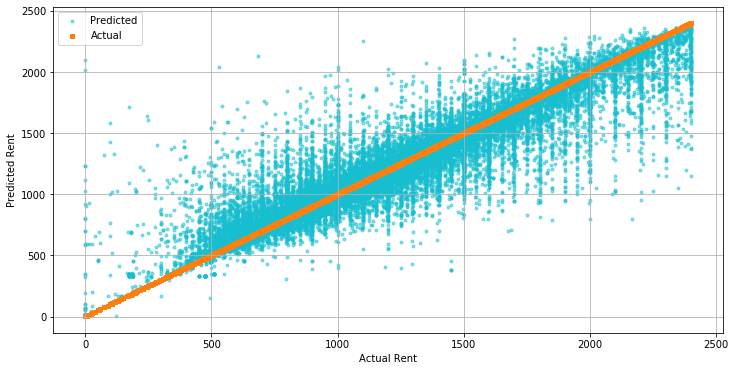

In [20]:
print('Random Forest Performance:')

print('\nall features, No scaling(train):')
print('Train MSE:', mean_squared_error(y_train, rf_pred_train))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, rf_pred_train)))
print('Train MAE:', mean_absolute_error(y_train, rf_pred_train))
print('R2_Score: ', r2_score(y_train, rf_pred_train))

print('\nall features, No scaling(test):')
print('Test MSE:', mean_squared_error(y_test, rf_pred_test))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, rf_pred_test)))
print('Test MAE:', mean_absolute_error(y_test, rf_pred_test))
print('R2_Score: ', r2_score(y_test, rf_pred_test))


# pred = pd.DataFrame(data={'Predicted_Rent': np.exp(rf_pred_test), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, rf_pred_test, color='tab:cyan', marker=".", label='Predicted', alpha='0.5')
ax1.scatter(y_test, y_test, s=10, color='tab:orange', marker="s", label='Actual')


plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(loc='upper left');
plt.grid()
plt.show()